In [3]:
# Download NEREL from GitHub repo
!git lfs install
!git clone https://github.com/nerel-ds/NEREL.git

Git LFS initialized.
Cloning into 'NEREL'...
remote: Enumerating objects: 3071, done.
remote: Counting objects: 100% (3071/3071), done.
remote: Compressing objects: 100% (2889/2889), done.
remote: Total 3071 (delta 1155), reused 2072 (delta 179), pack-reused 0
Receiving objects: 100% (3071/3071), 3.23 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (1155/1155), done.


In [4]:
# Install required modules
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=0aa1a13df2bafa597a30ea6fde7a1fff1d2c9984d2a84daebf3b03ab01167ab1
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 15.6 MB/s eta 0:00:00


In [5]:
# Useful imports
import numpy as np
from typing import Optional

# Graph usage
import random
import networkx as nx
import matplotlib.pyplot as plt

# Text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import pymorphy2

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")
nltk.download("omw-1.4")

def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)

seed_everything(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [20]:
class NerelParser:
    # Creates graph based on text data and relationships
    def __init__(self, path="/content/NEREL/NEREL-v1.1/"):
        self.path = path
        self.entities = []
        self.relations = []
        self._parse_annotation()

    def _parse_annotation(self):
        """
        Parse all possible names of entities and relations
        """
        # Start from a white list (forget previously introduced entities and relations)
        self.entities = []
        self.relations = []

        # Read data from "annotation.conf" file
        with open(self.path+"annotation.conf", "r") as f:
            # Boolean vars whether the line correspond to entity or relation
            entities = False
            relations = False

            for line in f:
                if line.isspace():
                    # We are not interested in spaces
                    pass

                # Update checkers if keywords were found
                elif "[entities]" in line:
                    entities = True
                elif "[relations]" in line:
                    relations = True
                    entities = False

                # Skip other metadata or lines
                elif "[" in line or line[0] == "<":
                    entities = False
                    relations = False

                # Parse entities and relations as first element in a line
                elif entities:
                    self.entities.append(line.split("\t")[0].split("\n")[0])
                elif relations:
                    self.relations.append(line.split("\t")[0].split("\n")[0])

    def get_sentence_from(self, path):
        # Read the first sentence from the text file
        sentence = []
        sent_len = 0
        with open(self.path+path+".txt", "r") as f:
            for line in f:
                lines = TextPreprocessor.split_to_sentence(line)[0]
                sent_len = len(line[0])
                sentence = TextPreprocessor.preprocess_sentence(line)
                if len(sentence) >= 1:
                    # We found a sentence with words
                    break

        if len(sentence) < 1:
            print("No sentences were found")
            return None, None
        else:
            return sentence, sent_len

    def parse_text_annotation(self, path="test/1130", length=None):
        """
        Extract entities and relations information from annotation to the file.
        Entity is represented as [type, [list of preprocessed words in the entity]]
        Relation - [type, index of entitiy 1, index of entitiy 2]

        :param path: path to the annotation file without the extension
        :param length: index of the last word (for analyzing part of the text)
        :return: (list of entities annotations, list of relations annotations)
        """
        entities_ann = []
        rels_ann = []
        with open(self.path+path+".ann", "r") as f:
            for line in f:

                if line[0] == 'T':
                    # Parse entity
                    entity = self._parse_entity(line, length=length)
                    if entity:
                        entities_ann.append(entity)

                elif line[0] == 'R':
                    # Parse relation
                    relation = self._parse_relation(line, last_idx=len(entities_ann)-1)
                    if relation:
                        rels_ann.append(relation)

        return entities_ann, rels_ann

    def _parse_entity(self, line, length=None):
        """
        Parse an entity annotation to a format
        [type, [list of words in entity]]

        :param line: string in a format
        "<id>\t<type> <start> <stop>\t<text>"
        :param length:
        :return: [type, [list of preprocessed words in entity]]
        """
        _, body, text = line.split("\t")
        t, start, stop = body.split(" ")
        words = TextPreprocessor.preprocess_sentence(text)
        start, stop = int(start), int(stop)

        return [t, words]

    def _parse_relation(self, line, last_idx=None):
        """
        Parse a relation annotation to a format [entity_1, entity_2, type]

        :param line: string in a format
        "<id>\t<type> Arg1:<arg1_id> Arg2:<arg2_id>"
        :param last_idx: last index in the entities list
        :return: [entity_1, entity_2, type]
        """
        _, body, _ = line.split("\t")
        t, arg1, arg2 = body.split(" ")

        # Calculate entities indexes
        arg1 = int(arg1.split(":")[1][1:]) - 1
        arg2 = int(arg2.split(":")[1][1:]) - 1

        if last_idx is not None and (last_idx < arg2 or last_idx < arg1):
            # Not all entities are in the sentence
            return None
        else:
            return [t, arg1, arg2]


class TextPreprocessor:
    # Perform text preprocessing

    def split_to_sentence(line):
        """
        Split a paragraph by sentences
        :return: list of sentences
        """
        sentences = sent_tokenize(line, language="russian")
        return sentences

    def preprocess_sentence(sentence):
        """
        Split the sentence into a list of tokenized stemmed words
        without punctuation
        :return: list of words
        """
        # Preparation of tools
        stop_words = set(stopwords.words('russian'))
        morph = pymorphy2.MorphAnalyzer()

        # Remove punctuation
        no_punct = sentence.translate(str.maketrans("", "", '.,?!\|/<>:;"^()[]{}+='))

        # Create tokens
        word_tokens = word_tokenize(no_punct)

        # Convert the words in word_tokens to lower case
        # Check whether they are present in stop_words or not
        # Stemm the present ones
        l = [morph.parse(w.lower())[0].normal_form for w in word_tokens if not (w.lower() in stop_words or w=='-')]

        return l

class Text2Graph:
    # Reformats annotations to graph
    def __init__(self):
        self.graph = nx.Graph([])
        # self.parser = parser
        seed_everything(42)



    def sentence_to_graph(self, sentence, entities_ann, rels_ann):

        # sentence, sent_len = self.parser.get_sentence_from(ex_path)
        # entities_ann, rels_ann = self.parser.parse_text_annotation(path=ex_path, length=sent_len)

        edge_list = []
        # Format: [ (Entity1, Entity2, {"relation_type": "Type"}) ]

        node_list = {w:{"node_type":[]} for w in list(set(sentence))}
        # Format: {Entity: {"node_type": ["Type1", Type2]} }

        # Add edges for near words
        for w in range(len(sentence)-1):
            edge_list.append((sentence[w], sentence[w+1], {"relation_type": "Near position"}))

        # Add entity types and relations inside entities
        for t, words in entities_ann:
            for w in range(len(words)):
                # Add node type to the nodes
                if words[w] in node_list.keys():
                    node_list[words[w]]["node_type"].append(t)

                    for other in words[w+1:]:
                        if other in node_list.keys() and other != words[w]:
                            edge_list.append((words[w], other, {"relation_type": t}))

        for node in node_list.keys():
            node_list[node]["node_type"]= list(set(node_list[node]["node_type"]))

        # Create relations
        for t, ind1, ind2 in rels_ann:

            words1 = entities_ann[ind1][1]
            words2 = entities_ann[ind2][1]

            # Iterate over each word pair and check if it
            for w1 in entities_ann[ind1][1]:
                if w1 in node_list.keys():
                    for w2 in entities_ann[ind2][1]:
                        if w1 != w2 and w2 in node_list.keys():
                            edge_list.append((w1, w2, {"relation_type": t}))

        # Create graph based on the obtained info
        print(edge_list)
        self.graph = nx.Graph(edge_list)
        nx.set_node_attributes(self.graph, node_list)

    def draw(self):
        # Draw a graph
        pos = nx.circular_layout(self.graph)
        edge_labels = nx.get_edge_attributes(self.graph, "relation_type")

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
        ax.set_axis_off()
        ax = fig.add_subplot(1, 1, 1)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, ax=ax, font_color='blue')
        nx.draw_networkx(self.graph, ax=ax, pos=pos, node_size=1000, with_labels=True, node_color='green')
        plt.axis("off")
        plt.show()

        # Print info about entities
        format_row = "{:<15}" * 2
        print("All nodes with attributes\n")
        print(format_row.format("Entity", 'Entity Type'))
        for node, attr in self.graph.nodes.data():
            print(format_row.format(node, ', '.join(attr['node_type'])))

        # Print info about relations
        print("\n\nAll edges with attributes\n")
        format_row = "{:<15}" * 3
        print(format_row.format("Entity", "Entity", 'Relation Type'))
        for node1, node2, attr in self.graph.edges.data():
            print(format_row.format(node1, node2, attr['relation_type']))

[('словацкий', 'тренер', {'relation_type': 'Near position'}), ('тренер', 'жолт', {'relation_type': 'Near position'}), ('жолт', 'хорняк', {'relation_type': 'Near position'}), ('хорняк', 'возглавить', {'relation_type': 'Near position'}), ('возглавить', 'бананца', {'relation_type': 'Near position'}), ('бананца', 'ереван', {'relation_type': 'Near position'}), ('жолт', 'хорняк', {'relation_type': 'PERSON'}), ('жолт', 'хорняк', {'relation_type': 'PERSON'}), ('тренер', 'бананца', {'relation_type': 'PROFESSION'}), ('жолт', 'бананца', {'relation_type': 'WORKPLACE'}), ('хорняк', 'бананца', {'relation_type': 'WORKPLACE'}), ('бананца', 'ереван', {'relation_type': 'HEADQUARTERED_IN'}), ('жолт', 'тренер', {'relation_type': 'WORKS_AS'}), ('хорняк', 'тренер', {'relation_type': 'WORKS_AS'}), ('жолт', 'словацкий', {'relation_type': 'ORIGINS_FROM'}), ('хорняк', 'словацкий', {'relation_type': 'ORIGINS_FROM'}), ('бананца', 'ереван', {'relation_type': 'HEADQUARTERED_IN'}), ('жолт', 'тренер', {'relation_type

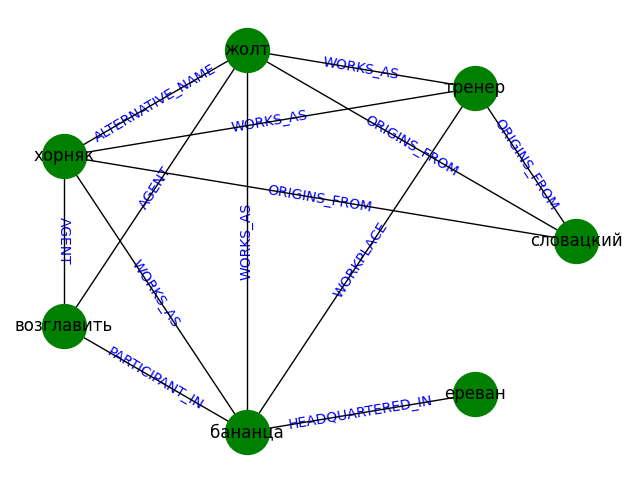

All nodes with attributes

Entity         Entity Type    
словацкий      NATIONALITY    
тренер         PROFESSION     
жолт           PERSON         
хорняк         PERSON         
возглавить     EVENT          
бананца        PROFESSION, ORGANIZATION
ереван         CITY           


All edges with attributes

Entity         Entity         Relation Type  
словацкий      тренер         ORIGINS_FROM   
словацкий      жолт           ORIGINS_FROM   
словацкий      хорняк         ORIGINS_FROM   
тренер         жолт           WORKS_AS       
тренер         бананца        WORKPLACE      
тренер         хорняк         WORKS_AS       
жолт           хорняк         ALTERNATIVE_NAME
жолт           бананца        WORKS_AS       
жолт           возглавить     AGENT          
хорняк         возглавить     AGENT          
хорняк         бананца        WORKS_AS       
возглавить     бананца        PARTICIPANT_IN 
бананца        ереван         HEADQUARTERED_IN


In [21]:
# parser = NerelParser()
# sentence, sent_len = parser.get_sentence_from("test/1130")
# entities_ann, rels_ann = parser.parse_text_annotation(path="test/1130", length=sent_len)
tg = Text2Graph()
tg.sentence_to_graph(sentence, entities_ann, rels_ann)
tg.draw()

Used resources:

https://networkx.org/documentation/stable/tutorial.html

https://python-school.ru/blog/nlp-text-preprocessing/

https://github.com/ridgerchu/SpikeGPT/blob/master/src/utils.py

https://huggingface.co/datasets/iluvvatar/NEREL

@article{loukachevitch2021nerel,
title={NEREL: A Russian Dataset with Nested Named Entities, Relations and Events},
author={Loukachevitch, Natalia and Artemova, Ekaterina and Batura, Tatiana and Braslavski, Pavel and Denisov, Ilia and Ivanov, Vladimir and Manandhar, Suresh and Pugachev, Alexander and Tutubalina, Elena},
journal={arXiv preprint arXiv:2108.13112},
year={2021}
}

https://github.com/nerel-ds/NEREL/tree/master

https://arxiv.org/pdf/2205.02767.pdf

https://arxiv.org/pdf/2006.15437.pdf